# 私有資料庫 dataset for dataloader

私有的資料庫在pytorch的dataloder使用方式，基本上和 torchvision 搭配 dataloader 中一樣


**<font color = white size=4>唯一不同的部分在於dataset的宣告。</font>**


""""""""""""""""""""""""""""""""<br>
**<font color = green size=4>dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)</font>**

""""""""""""""""""""""""""""""""<br>

<font color = white size=4> 此部分就是要介紹如何在pytorch自定義dataset，也就是「**dataset_MNIST_tensor = datasets.MNIST('./dataset')**」這行怎麼出來的</font><br>

## Dataset宣告
<font color = white size=4> 我們看一下pytorch自建dataset class的時候一定宣告有個三個function</font><br>

- 拿甚麼? -> def __init__(self)
- 拿多少? -> def __len__(self)
- 怎麼拿? -> def __getitem__(self, index)

In [ ]:
class Dataset_private(object):
    def __init__(self):
        pass

    def __getitem__(self, index):
        return 

    def __len__(self):
        return 

<font color = red size=6> def \__init__(self):</font> <br>
因為可能我們有100萬張圖片，我們無法全部都load到電腦的記憶體內，記憶體會爆掉。<br>
因此我們會將所有圖片的路徑檔寫成一個file list，我們在後面介紹的__getitem__就只要從這個file list去取出影像路徑在__getitem__裡面做圖片的讀取即可。

<font color = red size=6> def \__getitem__(self, index):</font> <br>
index這個項目滿有趣的<br>
他其實是從你定義的def \__len__內取到的資料庫長度下，抽取一個index(抽出不放回)。<br>
如果搭配的dataloader Shuffle=True，這個index則是隨機生成<br>
如果Shuffle=False，則index則是依造順序抽。<br>
1. 我們透過index來file list去，讀取數據
2. Data augumentation
3. Ground truth: 分類的類別、Bounday box、Segmentation map...之類的
4. **將資料轉換成torch tensor。**

<font color = red size=6> def \__len__(self):</font> <br>
需要宣告你資料庫的大小<br>
假設資料庫有100萬筆資料，如果你把這個項目寫成100，使用torch.utils.data.DataLoader讀你宣告的這個dataset，他會認為只有100筆資料。當他讀完100筆資料則會跳出loop。


### example 
假設我們有10筆資料順序是<br>
1,2,3,4,5,6,7,8,9,10<br>

如果搭配的dataloader Shuffle=True，這個index則是隨機生成(長度是根據\__len__宣告的)<br>
2,5,7,8,9,1,3,4,10,6<br>

|batch = 1|iter|index|batch = 4|iter|index|
|:---:|:---:|:---:|:---:|:---:|:---:|
||1|2| |1|2,5,7,8|
||2|5| |2|9,1,3,4|
||3|7| |3|10,6|
||4|8|
||5|9|
||6|1|
||7|3|
||8|4|
||9|10|
||10|6|








<font color = k size=3>上面看到的亂數產生方式就是上一份資料寫到的sampler</font> <br>
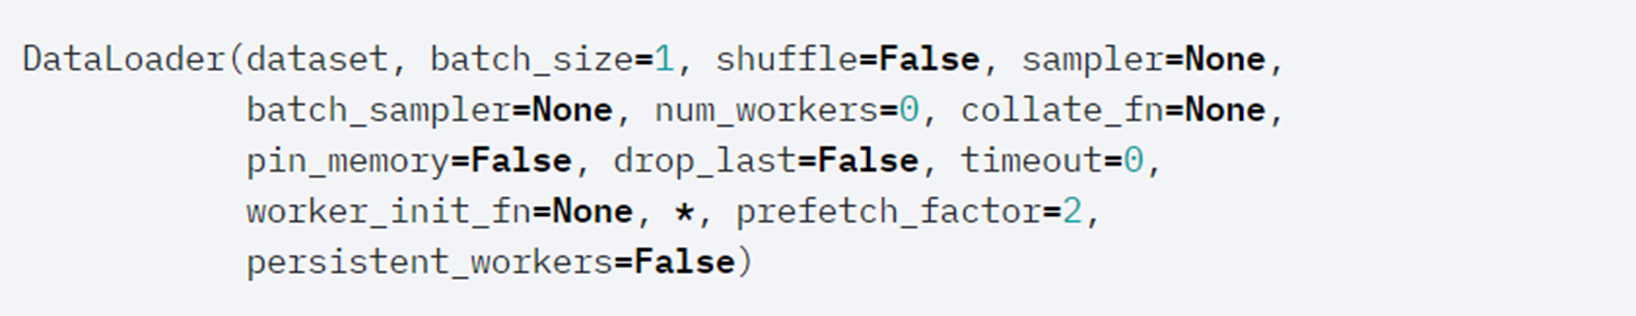


    



## 取資料方式
### 隨機抽樣
[Sampler](https://pytorch.org/docs/stable/data.html)方法
- torch.utils.data.SequentialSampler

- torch.utils.data.RandomSampler

- torch.utils.data.SubsetRandomSampler

<font color = gray size=4>注意: Sampler 是 return 索引值:</font>

In [26]:
import torch

# SequentialSampler 示例
sequential_sampler = f'SequentialSampler:\n\
{list(torch.utils.data.SequentialSampler(range(10)))}'

# RandomSampler 示例
random_sampler = f'\nRandomSampler:\n\
{list(torch.utils.data.RandomSampler(range(10)))}'

# SubsetRandomSampler 示例
subset_random_sampler = f'\nSubsetRandomSampler:\n\
{list(torch.utils.data.SubsetRandomSampler(range(10)))}'


print(sequential_sampler)

print(random_sampler)

print(subset_random_sampler)


SequentialSampler:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

RandomSampler:
[4, 9, 5, 0, 1, 8, 7, 6, 3, 2]

SubsetRandomSampler:
[7, 6, 2, 1, 0, 3, 8, 9, 4, 5]


### 權重抽樣

- torch.utils.data.WeightedRandomSampler(weights, num_samples, replacement=True, generator=None)<br>


weights: 每筆資料抽出來的權重<br>
num_samples: 總共多少筆資料<br>
replacement: True: 抽出放回, Flase:抽出不放回<br>

In [25]:
# WeightedRandomSampler 示例（取出放回）
weighted_sampler_with_replacement = f'\nWeightedRandomSampler(取出放回):\n\
{list(torch.utils.data.WeightedRandomSampler([0.1, 0.9, 0.1, 0.1, 3.0, 0.0], 5, replacement=True))}'

# WeightedRandomSampler 示例（取出不放回）
weighted_sampler_without_replacement = f'\nWeightedRandomSampler(取出不放回):\n\
{list(torch.utils.data.WeightedRandomSampler([0.9, 0.4, 0.05, 0.2, 0.3, 0.1], 5, replacement=False))}'


print(weighted_sampler_with_replacement)

print(weighted_sampler_without_replacement)


WeightedRandomSampler(取出放回):
[1, 4, 4, 4, 4]

WeightedRandomSampler(取出不放回):
[1, 3, 0, 4, 5]


### 批次抽樣

可以和 權重抽樣 或是 隨機抽樣 做組合

In [32]:


# BatchSampler + SequentialSampler 示例
batch_sequential_sampler = f'\nBatch sampler (batch = 3) + SequentialSampler\n \
{list(torch.utils.data.BatchSampler(torch.utils.data.SequentialSampler(range(10)), batch_size=3, drop_last=False))}'

# BatchSampler + RandomSampler 示例
batch_random_sampler = f'\nBatch sampler (batch = 3) + RandomSampler\n \
{list(torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(range(10)), batch_size=3, drop_last=True))}'


print(batch_sequential_sampler)
print(batch_random_sampler)


Batch sampler (batch = 3) + SequentialSampler
 [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

Batch sampler (batch = 3) + RandomSampler
 [[3, 5, 6], [2, 4, 9], [7, 8, 1]]


## 總結 dataloader 原理

透過不同索引的排列組合取資料!!

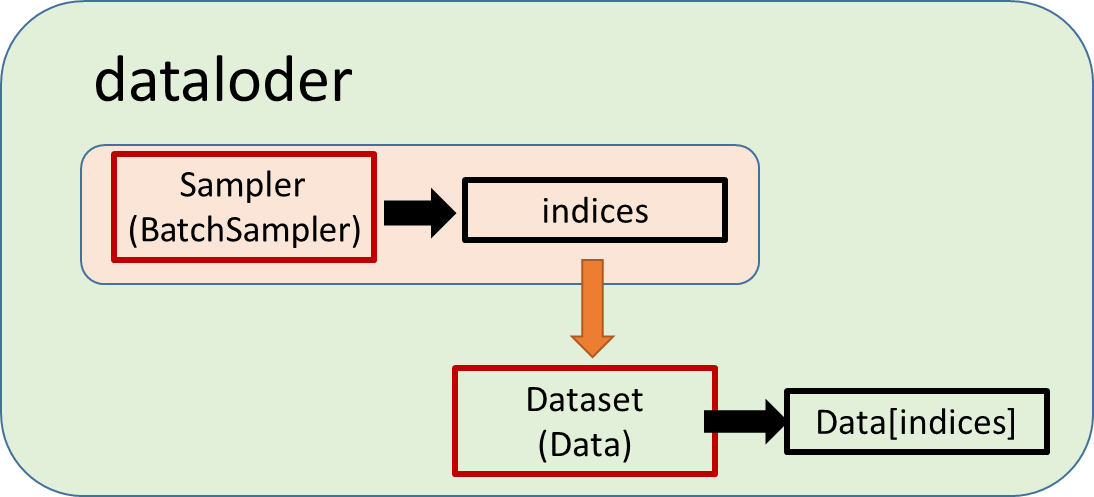

## 實作練習 kaggle 貓狗辨識

<font color = black size=4>**這邊我們用[貓狗辨識資料庫](https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip)來說明。<br>因避免版權問題，我不提供資料下載此資料庫，建議自行到Kaggle下載。**</font><br>
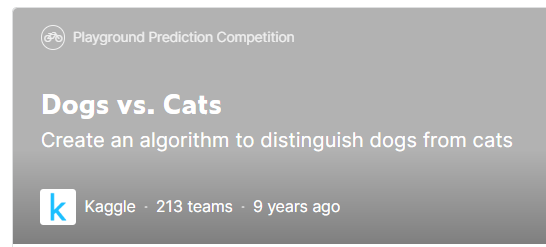

此資料庫一共有25000張訓練圖片

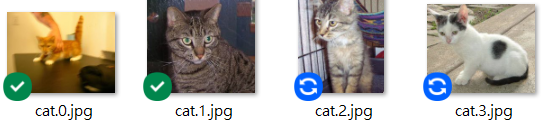

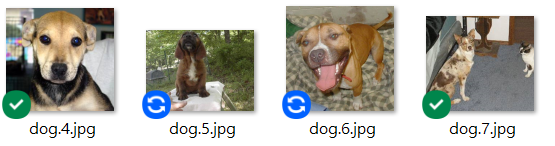

貓狗的類別已經被標住在圖片檔名上，見上圖。


## Deep Learning 建構策略 
(raw data ingestion-> data preprocess -> data traing -> dat validation)


### 1. raw data ingestion (考慮到版本控制)

所有的圖片路徑取出來，並且寫到一個json檔案，目的是當圖片如果達到一百萬張以上，這時候程式如果每一次都要重新parse一次所有路徑可能會花費很多時間，優點
- 只要Parse一次即可
- 路徑寫成json，檔案不會太大
- 不同時期的資料可以寫成不同的JSON進行資料控制。

### 2. data preprocess (資料前處理)

標籤編碼 (lable enconding)
狗是1，貓是0



In [34]:
mypath = './data/dogs-vs-cats/train/train'
import os
import numpy as np
import json

imagepaths, labels=[],[]
for (dirpath, _ , filenames) in os.walk(mypath):
    for tmp_filename in filenames:
        if 'cat' in tmp_filename:
            labels.append(0)
        elif 'dog' in tmp_filename:
            labels.append(1)
        imagepaths.append(os.path.join(dirpath, tmp_filename))
data={}
data['imagepaths']=imagepaths
data['labels']=labels
with open('./data/dogs-vs-cats/dogcat.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)
    

FileNotFoundError: [Errno 2] No such file or directory: './data/dogs-vs-cats/dogcat.json'

In [35]:
import torch
import numpy as np
import PIL.Image as Image
import torchvision.transforms.functional as FT
from torchvision import transforms
import json

mytransform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        ])

class MyDataset_CatDog(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self,mytransform):
        
        with open('./data/dogs-vs-cats/dogcat.json') as jsonfile:
            data_load = json.load(jsonfile)
        self.imList = data_load['imagepaths']
        self.labelList = data_load['labels']
        self.mytransform = mytransform
        print('number of total data:{}'.format(len(self.imList)))
        
    def __len__(self):
        return int(len(self.imList)/100)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
        
        # Convert PIL label image to torch.Tensor
        image = self.mytransform(image)
        label = torch.tensor(label)
        
        return image, label
    
    def my_collate(self,batch):
        data, targets = list(), list()
        for b in batch:
            data.append(b[0])
            targets.append(b[1])
        data = torch.stack(data,dim=0)
        targets = torch.stack(targets,dim=0)
        return data, targets

mydataset = MyDataset_CatDog(mytransform=mytransform)
mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=16, shuffle=True ,num_workers=0)
for data, targets in mydata_loader:
    print(data.size())
    print(targets.size())
    print(targets)
    break    


FileNotFoundError: [Errno 2] No such file or directory: './data/dogs-vs-cats/dogcat.json'

### Pytorch 圖片視覺化


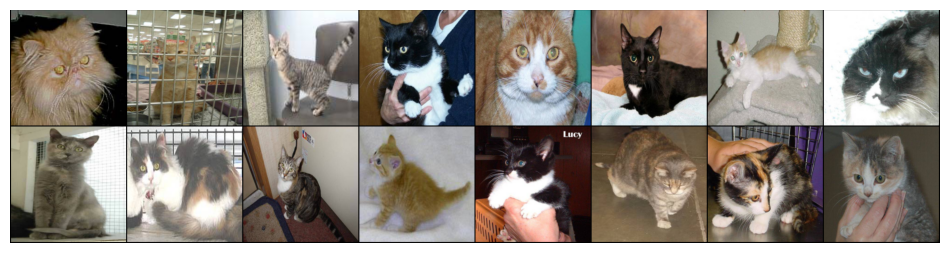

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

grid = make_grid(data)
def show(image):
    plt.figure(figsize=(12, 9))
    plt.imshow(np.transpose(image, [1, 2, 0]))
    plt.axis('off')
show(grid)
plt.show()
print(targets)

**<font color = blue size=4> workers在私有資料集測試 </font>**<br>

>**<font color = red size=3>Windows系統在舊版本的PyTorch不能(通常會有error)在自定義dataset處理num_workers>0，目前我用PyTorch 2.0此問題好像還是沒有解決，打開不會報錯，但系統就停住</font>**<br>

**我們這邊試著將worker打開做平行處理**<br>
**worker打開後會發生其他問題**

In [4]:
mydataset = MyDataset_CatDog(mytransform=mytransform)
mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=99, num_workers=0)
for data, target in mydata_loader:
    print(data.size())
    print(target.size())
         

number of total data:25000
torch.Size([99, 3, 224, 224])
torch.Size([99])
torch.Size([99, 3, 224, 224])
torch.Size([99])
torch.Size([52, 3, 224, 224])
torch.Size([52])


當num_workers>2，在Linux進行多執行緒會發生下面這個error<br>
**「RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 1 and 0 in dimension 1 at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensor.cpp:612」**
reference: https://discuss.pytorch.org/t/runtimeerror-invalid-argument-0-sizes-of-tensors-must-match-except-in-dimension-0-pls-help/40852

**<font color = red size=3> 原因在於 整個database資料數和batch size的關係</font>**<br>
> <font color = black size=3>我將整個database控制在250筆資料，batch size設為99是除不盡的，也就是最後一個iteration資料的shape會和前面的都不一樣，這個時候系統就會報錯誤。<br></font>

假設我num_workers設定為3，也就是3個CPU同時進行資料讀取的動作，每一個要讀99張圖。
電腦預期

|CPU ID|電腦預期張圖|實際讀取張數|
|:-:|:-:|:-:|
|0|99|99|
|1|99|99|
|2|99|52|

  
 
<font color = red size=3>解決方法: 在dataset的class宣告要多加一個collate_fn。</font><br>

然後我們要定義一個collate_fn用的function，可以一起定義在mydataset裡面，也可以額外定義function，通常是建議在mydataset定義會比較好。<br>
我前面dataset宣告已經建立，直接拿來用。<br>

**要測試num_workers>0 平行處理需在Linux系統處理，如果在Windows系統處理會陷入無止境的運算，然後檔案當掉。想測試collate_fn請至Linux來進行。**

In [5]:
mydataset = MyDataset_CatDog(mytransform=mytransform)
mydata_loader = torch.utils.data.DataLoader(mydataset, 
                                            batch_size=99, 
                                            num_workers=0, # 測試num_workers>0，請至Linux系統。
                                            collate_fn = mydataset.my_collate)
for data, target in mydata_loader:
    print(target.size())

number of total data:25000
torch.Size([99])
torch.Size([99])
torch.Size([52])


 **這邊我們測試看看如果需要讀圖檔下，開不開workers差多少，請在Linux(程式碼如下)下執行**<br>
 我將我在Linux執行的結果貼上來。
 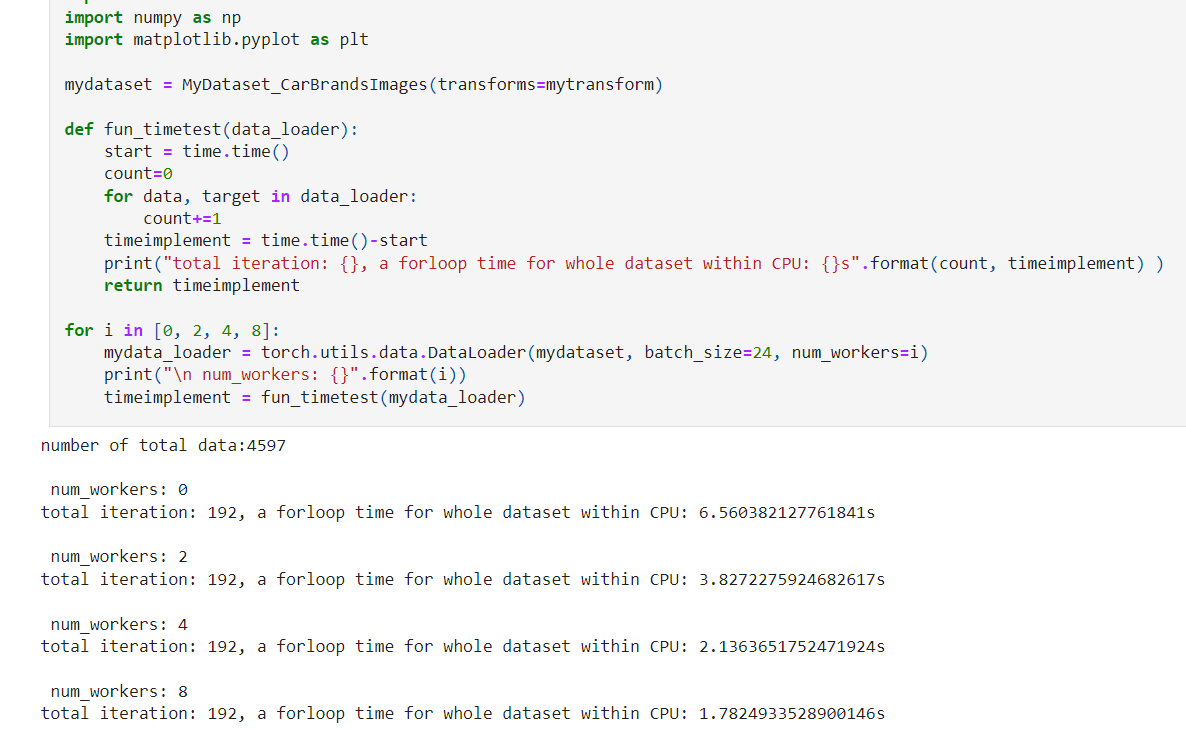

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

mydataset = MyDataset_CatDog(mytransform=mytransform)

def fun_timetest(data_loader):
    start = time.time()
    count=0
    for data, target in data_loader:
        count+=1
    timeimplement = time.time()-start
    print("total iteration: {}, a forloop time for whole dataset within CPU: {}s".format(count, timeimplement) )
    return timeimplement

for i in [0, 2, 4, 8]:
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=24, num_workers=i)
    print("\n num_workers: {}".format(i))
    timeimplement = fun_timetest(mydata_loader)



--------------------
**<font color = blue size=6 >III. 如何將資料丟到CUDA。</font>**


在torch的tensor下直接.to(device)即可，但device需要先宣告。

In [6]:
from torchvision import datasets, transforms
import torch
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2)


use_cuda = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

for data, target in mnistdata_loader:
    print(target)
    data, target = data.to(device), target.to(device)
    print(target)
    break

cuda:0
tensor([5, 0])
tensor([5, 0], device='cuda:0')


## 我們針對CPU mode的tensor和CUDA mode的tensor做操作看看

### 1. CPU Tensor 相加

In [7]:
use_cuda = 0
device = torch.device("cuda" if use_cuda else "cpu")
one = torch.Tensor([1])
for data, target in mnistdata_loader:
    print(data+one)
    break

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])


### 2. CUDA Tensor 加 CPU Tensor

In [8]:
one = torch.Tensor([1])
for data, target in mnistdata_loader:
    data, target = data.to(device), target.to(device)
    print(data)
    print(data+one)
    break

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
     

### 3. CUDA Tensor 加 CUDA Tensor

In [9]:
use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

one = torch.Tensor([1])
one = one.to(device)
for data, target in mnistdata_loader:
    data, target = data.to(device), target.to(device)
    print(target+one)
    break

cuda:0
tensor([6., 1.], device='cuda:0')


### 4. 測試CPU和CUDA之間資料搬移

In [10]:
import time
def test_time(data_loader):
    start = time.time()
    count=0
    for data, target in data_loader:
        count+=1
    print("a forloop time for whole dataset within CPU: {}s".format(time.time()-start))

    start = time.time()
    count=0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        count+=1
    print("a forloop time for whole dataset with CPU to CUDA: {}s".format(time.time()-start))
    
print("When batch size = 10")
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=10, shuffle=False)
test_time(mnistdata_loader)

print("\nWhen batch size = 2")
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2, shuffle=False)
test_time(mnistdata_loader)


When batch size = 10
a forloop time for whole dataset within CPU: 7.586830377578735s
a forloop time for whole dataset with CPU to CUDA: 9.026897192001343s

When batch size = 2
a forloop time for whole dataset within CPU: 9.425851106643677s
a forloop time for whole dataset with CPU to CUDA: 12.947002172470093s


</font>**<font color = black size=4 >Note: </font>**<br>

**<font color = black size=3 >1:資料跑來跑去一定花費data bandwidth，導致時間會變慢，所以在pytorch撰寫過程中要盡量避免資料在CPU和GPU之間跑來跑去。</font>**<br>

**<font color = black size=3 >2: 容易造成CPU的tensor和CUDA的tensor進行運算的error，在進行運算要注意是在CPU還是CUDA。</font>**
